Aggregated analysis of 45 pyroCb events' VIIRS detections (see previous script)

In [174]:
import xarray as xr
import earthaccess
import datetime as dt
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter,DayLocator
import os
import fsspec
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')

In [175]:
#define root working directory
root = '/projects/my-public-bucket/'

#read in pyrocbs file
pyrocbs = pd.read_csv(root + '/NRL_pyroCb_inventory_2023_v1.csv') #canadian only
pyrocbs = pyrocbs[pyrocbs.VIIRS_match==1]
pyrocbs.datetime = pd.to_datetime(pyrocbs.datetime, utc=True)

start = pd.to_datetime('2023/06/03', utc=True)
end = pd.to_datetime('2023/07/31', utc=True)
pyrocbs = pyrocbs[(pyrocbs.datetime > start) & ( pyrocbs.datetime < end)].reset_index(drop=True)
#subset of June/July VIIRS matches in Canada

In [176]:
'''
#rename fires with multiple pyrocbs to have unique names for each time
names, counts = np.unique(pyrocbs.fire_name, return_counts=True)
for i in range(len(names)):
    if counts[i] > 1:
        indices = pyrocbs[pyrocbs.fire_name==names[i]].index
        for j in range(len(indices)):
            pyrocbs.loc[indices[j], 'fire_name'] = pyrocbs.loc[indices[j], 'fire_name'] + '_' + str(j+1)
pyrocbs
'''

"\n#rename fires with multiple pyrocbs to have unique names for each time\nnames, counts = np.unique(pyrocbs.fire_name, return_counts=True)\nfor i in range(len(names)):\n    if counts[i] > 1:\n        indices = pyrocbs[pyrocbs.fire_name==names[i]].index\n        for j in range(len(indices)):\n            pyrocbs.loc[indices[j], 'fire_name'] = pyrocbs.loc[indices[j], 'fire_name'] + '_' + str(j+1)\npyrocbs\n"

In [ ]:
#pyrocbs.to_csv(root + '/NRL_pyroCb_inventory_2023_v1.csv'

Text(0.5, 1.0, '45 VIIRS-observed pyroCb events in June-July 2023')

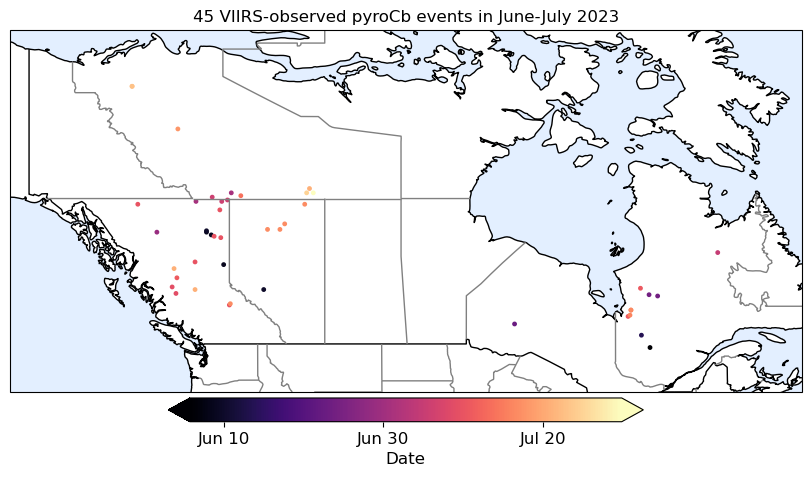

In [177]:
pyrocbs['mdates'] = mdates.date2num(pyrocbs.datetime)

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

fig, ax = plt.subplots(1,1, constrained_layout=True, subplot_kw={'projection':ccrs.Miller()}, figsize=(8,6))

ax.set_extent([-143,-60,45,65])
#ax.stock_img()
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.COASTLINE, zorder=1, edgecolor='k')
ax.add_feature(cfeature.BORDERS, zorder=1, edgecolor='k')
ax.add_feature(cfeature.OCEAN, facecolor='#e3efff')

plot = ax.scatter(pyrocbs.lon, pyrocbs.lat, c=pyrocbs.mdates, cmap='magma', s=6, transform=ccrs.Geodetic())
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.6, pad=0.01, extend='both', ax=ax, ticks=DayLocator(interval=20),format=DateFormatter('%b %-d'))
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Date', size=12)
cbar.ax.tick_params(rotation=0)
ax.set_title('45 VIIRS-observed pyroCb events in June-July 2023')

Text(0.5, 1.0, 'Fire 260')

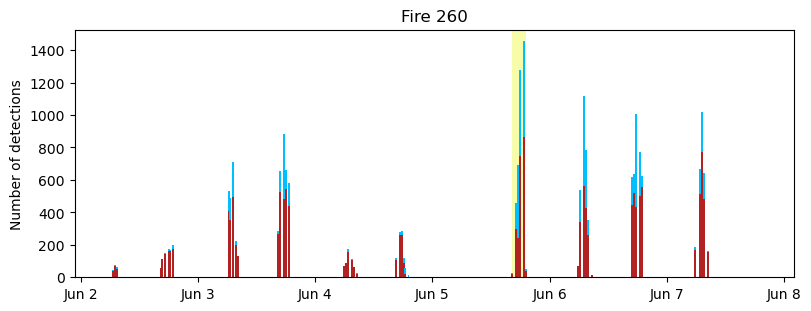

In [178]:
#sample summary file

fire = pyrocbs.loc[0, 'fire_name']
ptime = pyrocbs.loc[0, 'datetime']
summary = pd.read_csv(f'{root}/viirs/outputs/pyrocbs/{fire}/detections_summary.csv')
summary.acq_datetime = pd.to_datetime(summary.acq_datetime)
summary = summary.sort_values('acq_datetime')
summary['mdates'] = mdates.date2num(summary.acq_datetime)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 3))
ax.axvline(ptime, c='#f7fca9', zorder=1, linewidth=10)
ax.bar(summary.mdates, summary.n_known, width=1/24/60*24, color='firebrick')
ax.bar(summary.mdates, summary.n_cand, bottom=summary.n_known, width=1/24/60*24, color='deepskyblue')
#ax.plot(summary.mdates, summary.n_known)

#locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
locator = mdates.DayLocator(interval=1)
#formatter = mdates.ConciseDateFormatter(locator)
formatter = mdates.DateFormatter('%b %-d')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Number of detections')
ax.set_title('Fire ' + fire)

In [182]:
summary = pd.DataFrame()
for i in pyrocbs.index:
    fire = pyrocbs.loc[i, 'fire_name']
    ptime = pyrocbs.loc[i, 'datetime']
    s = pd.read_csv(f'{root}/viirs/outputs/pyrocbs/{fire}/detections_summary.csv')
    s.acq_datetime = pd.to_datetime(s.acq_datetime)
    
    s['rel_datetime'] = s.acq_datetime - ptime
    s['fire'] = fire
    
    summary = pd.concat([summary, s])

summary = summary[(summary.rel_datetime > dt.timedelta(-5)) & (summary.rel_datetime < dt.timedelta(4))] #will fix later
summary['round_datetime'] = summary.rel_datetime.dt.round('H')
summary

,acq_datetime,satellite,cloud_frac,fire_frac,n_cand,n_known,sza,j,rel_datetime,fire,round_datetime
0,2023-06-02 05:42:00+00:00,SNPP,0.006724,0.000000,0.0,0.0,108.375191,39.0,-4 days +12:02:00,260,-4 days +12:00:00
1,2023-06-02 07:24:00+00:00,SNPP,0.000998,0.000771,8.0,53.0,101.916420,3970.5,-4 days +13:44:00,260,-4 days +14:00:00
2,2023-06-02 17:12:00+00:00,SNPP,0.000000,0.001710,6.0,146.0,26.626575,4613.0,-4 days +23:32:00,260,-3 days +00:00:00
3,2023-06-02 18:54:00+00:00,SNPP,0.000000,0.003712,19.0,177.0,34.837254,555.5,-3 days +01:14:00,260,-3 days +01:00:00
4,2023-06-03 07:06:00+00:00,SNPP,0.000000,0.008175,215.0,493.0,103.475342,3158.0,-3 days +13:26:00,260,-3 days +13:00:00
...,...,...,...,...,...,...,...,...,...,...,...
79,2023-07-31 10:12:00+00:00,NOAA21,0.010525,0.015021,226.0,843.0,94.847595,3905.0,1 days 13:12:00,SS034-23 and SS046-23 (see notes),1 days 13:00:00
80,2023-07-31 11:48:00+00:00,NOAA21,0.072864,0.002985,171.0,0.0,85.629433,6264.0,1 days 14:48:00,SS034-23 and SS046-23 (see notes),1 days 15:00:00
81,2023-07-31 18:24:00+00:00,NOAA21,0.634382,0.000119,11.0,1.0,43.809238,5395.5,1 days 21:24:00,SS034-23 and SS046-23 (see notes),1 days 21:00:00
82,2023-07-31 20:00:00+00:00,NOAA21,0.763980,0.000983,28.0,23.0,42.612820,2554.5,1 days 23:00:00,SS034-23 and SS046-23 (see notes),1 days 23:00:00


In [131]:
summary.to_csv(f'{root}/viirs/outputs/pyrocbs/summary.csv')

In [183]:
grouped = summary.groupby('round_datetime').sum()
grouped['mdates'] = mdates.date2num(grouped.index)
grouped

/tmp/ipykernel_457/1458344162.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = summary.groupby('round_datetime').sum()


,cloud_frac,fire_frac,n_cand,n_known,sza,j,mdates
round_datetime,,,,,,,
-4 days +09:00:00,0.000000,0.003467,2.0,30.0,93.469963,12.5,-3625.000000
-4 days +10:00:00,1.401753,0.027914,183.0,1060.0,1102.998039,7153.5,-3583.333333
-4 days +11:00:00,6.982113,0.092434,590.0,4160.0,3660.294357,52074.0,-3541.666667
-4 days +12:00:00,8.247744,0.114116,1304.0,5033.0,5556.759933,137597.0,-3500.000000
-4 days +13:00:00,11.252886,0.109154,1578.0,5878.0,6034.391502,232666.0,-3458.333333
...,...,...,...,...,...,...,...
3 days 13:00:00,0.222432,0.007225,81.0,533.0,188.417427,11982.5,3541.666667
3 days 21:00:00,0.057896,0.007866,167.0,497.0,31.028385,5889.5,3875.000000
3 days 22:00:00,0.282582,0.032095,427.0,1791.0,60.397736,9184.0,3916.666667


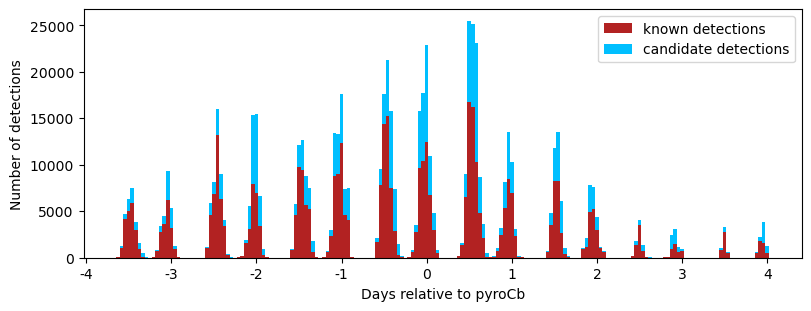

In [232]:
ptime = dt.timedelta(0)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 3))
#ax.axvline(ptime, c='#f7fca9', zorder=1, linewidth=10)
ax.bar(grouped.mdates, grouped.n_known, width=1000/24, color='firebrick', label='known detections')
ax.bar(grouped.mdates, grouped.n_cand, bottom=grouped.n_known, width=1000/24, color='deepskyblue', label='candidate detections')
#ax.plot(summary.mdates, summary.n_known)

#locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
#locator = mdates.HourLocator(interval=12)
#formatter = mdates.ConciseDateFormatter(locator)
#formatter = mdates.DateFormatter('%b %-d')
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Number of detections')
ax.set_xticks(np.arange(-4000,4001, 1000))
ax.set_xticklabels(np.arange(-4,5, 1))
ax.set_xlabel('Days relative to pyroCb')
ax.legend()

Quick stats

In [212]:
#total
summary.n_cand.sum() / summary.n_known.sum() * 100

53.16149605369955

In [211]:
#4 hour window
subset = summary[(summary.rel_datetime < dt.timedelta(hours=4)) & (summary.rel_datetime > dt.timedelta(hours=-4)) ]
subset.n_cand.sum()  / subset.n_known.sum() * 100

67.6614428239181

In [213]:
#1 hour window
subset = summary[(summary.rel_datetime < dt.timedelta(hours=1)) & (summary.rel_datetime > dt.timedelta(hours=-1)) ]
subset.n_cand.sum()  / subset.n_known.sum() * 100

76.53205976924532

In [219]:
#30 min window
subset = summary[(summary.rel_datetime < dt.timedelta(hours=0.5)) & (summary.rel_datetime > dt.timedelta(hours=-0.5)) ]
subset.n_cand.sum()  / subset.n_known.sum() * 100

84.32733435558066

In [218]:
#15 min window
subset = summary[(summary.rel_datetime < dt.timedelta(hours=0.25)) & (summary.rel_datetime > dt.timedelta(hours=-0.25)) ]
subset.n_cand.sum()  / subset.n_known.sum() * 100

102.56956274843839

In [216]:
#outside 4 hour window
subset = summary[(summary.rel_datetime > dt.timedelta(hours=4)) | (summary.rel_datetime < dt.timedelta(hours=-4)) ]
subset.n_cand.sum()  / subset.n_known.sum() * 100

51.35527523991906

In [220]:
#decrease in number of known detections during the pyroCb
subset = summary[(summary.rel_datetime > dt.timedelta(hours=-20)) & (summary.rel_datetime < dt.timedelta(hours=-6)) ]
subset.n_known.sum()

49832.0

In [221]:
#4 hour window
subset = summary[(summary.rel_datetime < dt.timedelta(hours=4)) & (summary.rel_datetime > dt.timedelta(hours=-4)) ]
subset.n_known.sum()

46007.0

In [223]:
grouped.to_csv(f'{root}/viirs/outputs/pyrocbs/grouped.csv')

In [202]:
subset

,acq_datetime,satellite,cloud_frac,fire_frac,n_cand,n_known,sza,j,rel_datetime,fire,round_datetime
16,2023-06-05 17:54:00+00:00,SNPP,0.362980,0.015794,528.0,750.0,28.457834,2823.0,0 days 00:14:00,260,0 days 00:00:00
36,2023-06-05 17:06:00+00:00,NOAA20,0.309307,0.005841,162.0,298.0,26.162418,4835.5,-1 days +23:26:00,260,-1 days +23:00:00
58,2023-06-05 17:30:00+00:00,NOAA21,0.325965,0.008588,445.0,245.0,26.762774,3914.0,-1 days +23:50:00,260,0 days 00:00:00
17,2023-06-08 20:24:00+00:00,SNPP,0.034450,0.010487,339.0,482.0,34.733688,3628.0,-1 days +23:24:00,2023-G80633,-1 days +23:00:00
45,2023-06-08 21:12:00+00:00,NOAA20,0.115982,0.016392,295.0,710.0,36.803795,1921.0,0 days 00:12:00,2023-G80633,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
23,2023-07-24 21:06:00+00:00,SNPP,0.586804,0.000000,0.0,0.0,44.084389,979.5,-1 days +23:46:00,SS022-23,0 days 00:00:00
69,2023-07-24 20:36:00+00:00,NOAA21,0.366332,0.002136,21.0,86.0,42.140602,1720.0,-1 days +23:16:00,SS022-23,-1 days +23:00:00
11,2023-07-29 21:12:00+00:00,SNPP,0.407041,0.025653,876.0,147.0,45.466209,684.0,0 days 00:12:00,SS034-23 and SS046-23 (see notes),0 days 00:00:00
41,2023-07-29 20:18:00+00:00,NOAA20,0.265780,0.025789,958.0,271.0,42.685040,2176.5,-1 days +23:18:00,SS034-23 and SS046-23 (see notes),-1 days +23:00:00


In [ ]:
#also plot the % of candidates otherwise classified as "cloud", "water" over time
#next steps also to overlay FEDS (day) and FEDS (night) perimeters during these events